In [1]:

import sys
import os
# Adds the project root directory to the Python path.
# The notebook is in 'Examples/pde', so we need to go up two levels.
project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)



In [2]:
!pip install pandas

In [3]:
from pysymmetry import *
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import time

# --- Plotting Configuration for Publication Quality ---
font = {'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True) # Use LaTeX for rendering text
plt.rc('lines', linewidth=2.5, markersize=8)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--', alpha=0.6)


# --- Helper Functions ---
def generators2d(n):
    # (Implementation remains the same)
    string_reflexao_sigma = ''
    for j in range(1,(n/2+1).floor()):
        for k in range(0,n):
            string_reflexao_sigma = string_reflexao_sigma + str((k*n+j,k*n+n-j+1))
    
    string_reflexao_miDp = ''
    for i in range(1, n):
        for j in range(i+1, n+1):            
            string_reflexao_miDp = string_reflexao_miDp + str(((i-1)*n+j,(j-1)*n+i))
            
    return [string_reflexao_sigma, string_reflexao_miDp]

def calculate_block_eigenvalues(block):
    """Helper function for parallel eigenvalue calculation."""
    return np.linalg.eigvals(block.toarray())

# --- Experiment Parameters ---
# Use a wider range of sizes to demonstrate scalability.
# Start small and increase significantly.
grid_sizes = np.array([ 60, 70, 80, 90])
matrix_dimensions = grid_sizes**2

# --- Data Storage ---
timings = {
    "preprocessing": [],
    "block_eigvals": [],
    "total_symmetry": [],
    "full_matrix": []
}


In [ ]:
# --- Main Timing Loop ---
# Use a context manager for the parallel pool.
D_coeff = 1.0  # Coeficiente de difusão
vx_velocity = 20.0 # Velocidade de advecção (aumente para ver mais diferença)
with Pool() as p:
    for n in grid_sizes:
        N = n**2
        print(f"Processing grid {n}x{n} (Matrix dimension: {N}x{N})...")
        print(f"  (Advection-Diffusion with D={np.round(D_coeff)}, vx={np.round(vx_velocity)})")
        
        # --- 1. Symmetry Method: Preprocessing ---
        start_time = time.perf_counter()
        #M = laplacian2d(n)
        M = advection_diffusion_2d(n, D=D_coeff, vx=vx_velocity)
        G = nFiniteGroup(generators2d(ZZ(n)))
        gens = G.gens()
        img = [g.matrix() for g in gens]
        r = G.nrepresentation(gens, img)
        base = G.nbase_change_reduction(r)
        blocks = base.get_blocks(M)
        t_preprocessing = time.perf_counter() - start_time
        timings["preprocessing"].append(t_preprocessing)
        print(f"  Preprocessing time: {t_preprocessing:.4f}s")

        # --- 2. Symmetry Method: Block Eigenvalue Calculation (Parallel) ---
        start_time = time.perf_counter()
        # Use pool.map for a cleaner parallel execution
        block_eigenvalues_list = p.map(calculate_block_eigenvalues, blocks)
        t_block_eigvals = time.perf_counter() - start_time
        timings["block_eigvals"].append(t_block_eigvals)
        print(f"  Block eigenvalues time: {t_block_eigvals:.4f}s")
        
        # Total time for the symmetry method
        total_sym_time = t_preprocessing + t_block_eigvals
        timings["total_symmetry"].append(total_sym_time)
        print(f"  Total symmetry method time: {total_sym_time:.4f}s")

        # --- 3. Full Matrix Method ---
        start_time = time.perf_counter()
        # We already have M, just need to convert and calculate
        full_eigenvalues = np.linalg.eigvals(M.toarray())
        t_full = time.perf_counter() - start_time
        timings["full_matrix"].append(t_full)
        print(f"  Full matrix time: {t_full:.4f}s\n")

print("Performance analysis complete.")

Processing grid 60x60 (Matrix dimension: 3600x3600)...
  (Advection-Diffusion with D=1.00000000000000, vx=20.0000000000000)
  Preprocessing time: 5.5044s
  Block eigenvalues time: 0.4114s
  Total symmetry method time: 5.9158s
  Full matrix time: 17.3326s

Processing grid 70x70 (Matrix dimension: 4900x4900)...
  (Advection-Diffusion with D=1.00000000000000, vx=20.0000000000000)
  Preprocessing time: 10.0594s
  Block eigenvalues time: 0.9561s
  Total symmetry method time: 11.0155s
  Full matrix time: 43.1578s

Processing grid 80x80 (Matrix dimension: 6400x6400)...
  (Advection-Diffusion with D=1.00000000000000, vx=20.0000000000000)
  Preprocessing time: 18.1250s
  Block eigenvalues time: 2.0152s
  Total symmetry method time: 20.1402s
  Full matrix time: 106.1411s

Processing grid 90x90 (Matrix dimension: 8100x8100)...
  (Advection-Diffusion with D=1.00000000000000, vx=20.0000000000000)
  Preprocessing time: 32.2050s
  Block eigenvalues time: 3.8976s
  Total symmetry method time: 36.1026s

--- Performance Results ---


,Grid Size,Matrix Dim (N),T_preprocess (s),T_blocks_eig (s),T_symmetry_total (s),T_full_matrix (s),Speedup
0,60x60,3600,5.5044,0.4114,5.9158,17.3326,2.9299
1,70x70,4900,10.0594,0.9561,11.0155,43.1578,3.9179
2,80x80,6400,18.1250,2.0152,20.1402,106.1411,5.2701
3,90x90,8100,32.2050,3.8976,36.1026,183.5496,5.0841


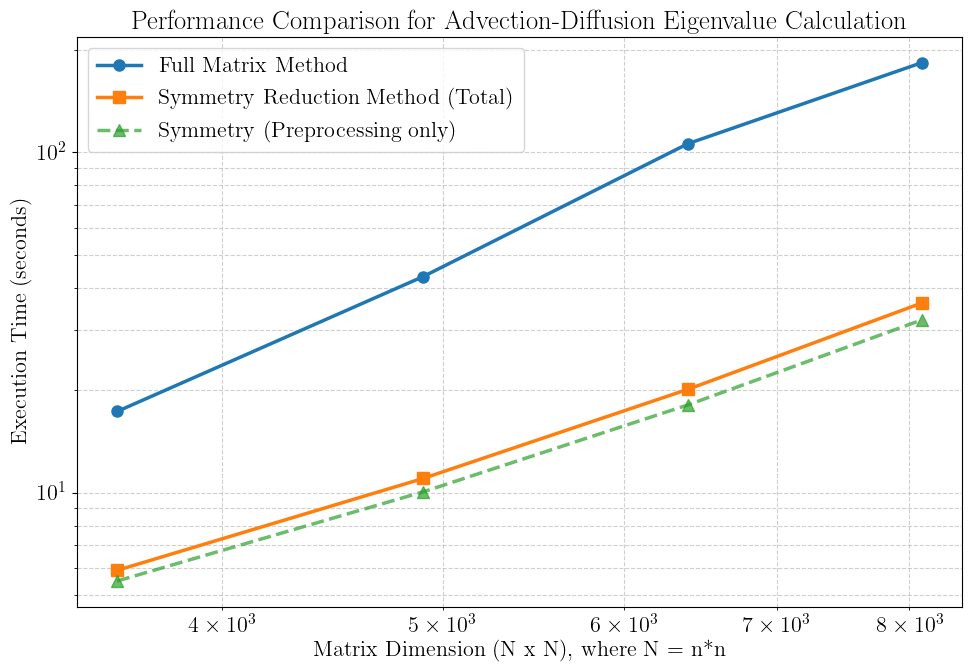

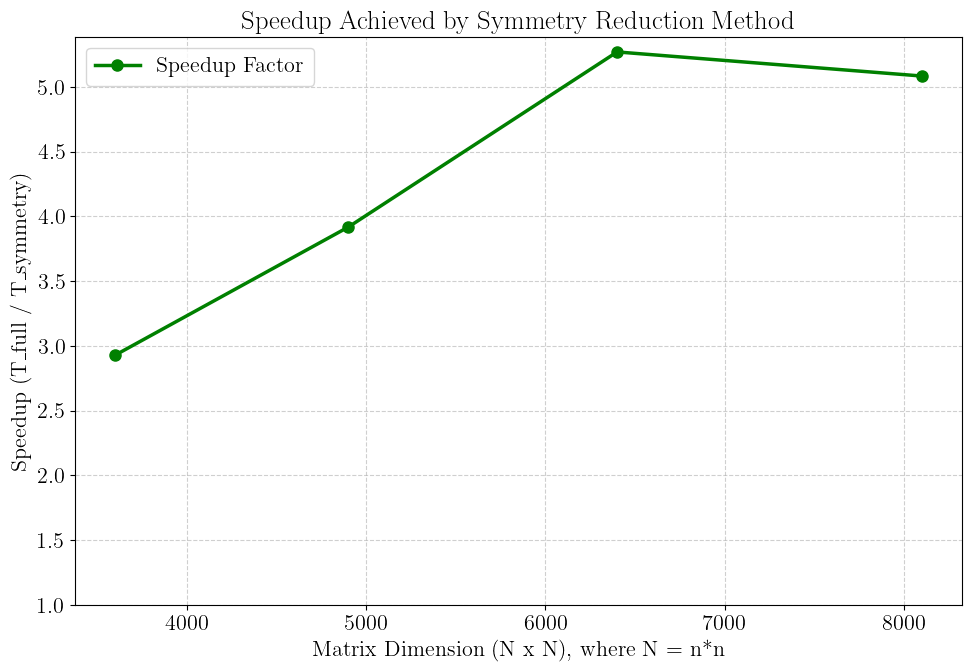

In [7]:
import pandas as pd

# --- 1. Create a DataFrame for a professional table display ---
df_timings = pd.DataFrame({
    'Grid Size': [f"{n}x{n}" for n in grid_sizes],
    'Matrix Dim (N)': matrix_dimensions,
    'T_preprocess (s)': timings['preprocessing'],
    'T_blocks_eig (s)': timings['block_eigvals'],
    'T_symmetry_total (s)': timings['total_symmetry'],
    'T_full_matrix (s)': timings['full_matrix']
})

# Calculate speedup
df_timings['Speedup'] = df_timings['T_full_matrix (s)'] / df_timings['T_symmetry_total (s)']

print("--- Performance Results ---")
display(df_timings.round(int(4)))


# --- 2. Plot 1: Log-Log plot of execution time vs. matrix dimension ---
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(matrix_dimensions, timings['full_matrix'], 'o-', label='Full Matrix Method')
ax.loglog(matrix_dimensions, timings['total_symmetry'], 's-', label='Symmetry Reduction Method (Total)')
ax.loglog(matrix_dimensions, timings['preprocessing'], '^--', label='Symmetry (Preprocessing only)', alpha=0.7)

ax.set_xlabel('Matrix Dimension (N x N), where N = n*n')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Performance Comparison for Advection-Diffusion Eigenvalue Calculation')
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


# --- 3. Plot 2: Speedup plot ---
fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.plot(matrix_dimensions, df_timings['Speedup'], 'o-', color='green', label='Speedup Factor')
ax2.set_xlabel('Matrix Dimension (N x N), where N = n*n')
ax2.set_ylabel('Speedup (T_full / T_symmetry)')
ax2.set_title('Speedup Achieved by Symmetry Reduction Method')
ax2.legend()
ax2.grid(True, which="both", ls="--")
# Set y-axis to start at 1, as speedup < 1 means a slowdown
ax2.set_ylim(bottom=1) 
plt.tight_layout()
plt.show()